# Neural Pricing

Codigo POC de implementación del paper de [DeLis [2021]](https://arxiv.org/pdf/2105.13320.pdf).


In [1]:
!poetry run python -m pip install torchsde


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!poetry run python -m pip -V

pip 22.1.2 from /home/gflan/.cache/pypoetry/virtualenvs/ancufi--w791oWn-py3.8/lib/python3.8/site-packages/pip (python 3.8)


In [204]:
import torch
from torch import nn
import torchsde
import numpy as np

import os
import sys
import tqdm

In [205]:
# cargar todo en GPU de ser posible
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

## Modelos

Generamos la clase de Multilayer Perceptron para generalizar y usar más adelante. 

* `in_size: int` variables de entrada
* `out_size: int` variables de salida
* `mlp_size: int` es la cantidad de nodos por capa
* `num_layers: int` la cantidad de capas internas del modelo
* `tanh: bool` decide entre tangente hiperbolica o leaky ReLu como función de activación

In [206]:
class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()        
        
        activation = lambda : torch.nn.Tanh() if tanh else torch.nn.LeakyReLU(0.01) 
        model = [
            torch.nn.Linear(in_size, mlp_size),
            activation()
        ]
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(activation())
        model.append(torch.nn.Linear(mlp_size, out_size))

        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

Neural SDE: SDE con redes neuronales de drift y difusión.

Entrenamos el modelo general de una SDE con $\mu_{\theta}$ y $\sigma_{\phi}$ los procesos de drift y difusión parametrizados por $\theta$ y $\sigma$ representando los pesos 'aprendibles' en entrenamiento.

$$ dS_t = \underbrace{\mu_{\theta}(t, S_t)}_{\text{drift}}dt + \underbrace{\sigma_{\phi}(t, S_t)}_{\text{difusión}}dB_t $$

In [207]:
class SDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self, state_size=1, batch_size=32, mlp_size=100, num_layers=3, tanh=False):
        super().__init__()
        
        in_size = 2 * state_size # S(t) y t
        out_size = state_size # drift o difusion final
        mu_sigma_args = dict(
            in_size=in_size,
            out_size=out_size,
            mlp_size=mlp_size, 
            num_layers=num_layers,
            tanh=tanh
        )
        self.mu = MLP(**mu_sigma_args)
        self.sigma = MLP(**mu_sigma_args)

    # Drift
    def f(self, t, y):
        # forward prop de la f
        # armar un tensor de batch_size componentes con el tiempo t
        batch_t = torch.full((batch_size,1), t.item()).to(device)
        # mu([
        #     (y_0, t), 
        #     (y_1, t),
        #     .. 
        #     (y_n, t) <--- n = batch_size
        # ]) 
        return self.mu(torch.cat((y, batch_t), dim=1))  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        # idem mu
        batch_t = torch.full((batch_size,1), t.item()).to(device)
        return self.sigma(torch.cat((y, batch_t), dim=1))

# sde = SDE().to(device)

Browniano Geométrico como benchmark conocido.

$$ dS_t = \mu S_t \ dt + \sigma \ S_t \ dB_t $$

In [208]:
class GBM_SDE(nn.Module):

    def __init__(self, mu, sigma):
        super().__init__()
        self.noise_type="diagonal"
        self.sde_type = "ito"

        self.mu = mu
        self.sigma = sigma

    def f(self, t, y):
        return self.mu * y

    def g(self, t, y):
        return self.sigma * y

## Earth Mover's (Wasserstein) Distance

Nuestra loss function va a ser la distancia Wasserstein $d=1$ dada por Ramdas et al. [2015]

$$ W_1 = \int_0^1 \big|F^{-1}(z) - G^{-1}(z)\big|\ dz $$

Con $F$ y $W$ las funciones de distribuciones acumulativas. Intuitivamente mide la distancia horizontal entre mis dos distribuciones.

Implemetamos la integral en pytorch con una discretización basada en percentiles sobre nuestras distribuciones empíricas. 

$P$ y $Q$ consistirán de tensores con una dimensión para cada batch y otra para cada intervalo de la discretización del browniano. Percentil a percentil se restan los valores absolutos para cada estado de esta discretización por separado y se suman, generando `brownian_size` distancias entre todos el batch.

$$ W_1 \simeq \sum_{i=1}^{n} \big|F^{-1}(p_i) - G^{-1}(p_i)\big|\ \frac{1}{N} $$

$$ 0 = p_0 < p_1 <\ ..\ < p_n = 1 $$

In [209]:
def emd(p, q, qtiles=11):
    quantiles = torch.linspace(0, 1, steps=qtiles, device=device) 
    # tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000])
    p_q = torch.quantile(p, quantiles, dim=1, keepdim=True)
    q_q = torch.quantile(q, quantiles, dim=1, keepdim=True)

    # sumo todas las diferencias quartil a quartil 
    return torch.abs(p_q - q_q).sum(dim=0).div(qtiles)

In [210]:
# Dos normales con misma varianza y un shift de una unidad de media, emd ~= 1 

p = torch.normal(mean=1, std=1, size=(5,300,1), requires_grad=True, device=device)
q = torch.normal(mean=0, std=1, size=(5,300,1), requires_grad=True, device=device)
print(p.shape) # (cantidad de instantes, tamaño del batch, cantidad de 'estados')

res = emd(p, q, qtiles=10)
print(res[:, 0, 0], res.mean())
del res, p, q

torch.Size([5, 300, 1])
tensor([0.9749, 0.9497, 1.1224, 0.9805, 1.1942], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)


### TorchSDE

Solvers de SDEs diferenciables que podemos usar en el entrenamiento de nuestra red.

* La función `torchsde.BrownianInterval` nos va a generar sobre un `ts` (de longitud `batch_size`) trazas discretas de un browniano respetando $ W_t - W_s \sim \mathcal{N}(0, t-s) $ para $0 \leq s < t$.

* `torchsde.sdeint` provee soluciones numéricas aproximadas sobre estas discretizaciones, por ejemplo mediante _Euler-Maruyama_:

$$ S_T = S_{t_0} + \int_{t_0}^T \mu(S_t, t) dt + \int_{t_0}^T \sigma(S_t, t) dW_t $$ 
$$ \implies $$
$$ S_{n+1} = S_n + \mu(S_n, t_n)\Delta t + \sigma(S_n, t_n) \underbrace{(W_n - W_{n-1})}_{\Delta W_n} $$ 



In [211]:
# y0 dimension (batch_size, state_size) da el valor inicial de la SDE en tiempo ts[0]
brownian_size, batch_size, state_size,  = 3, 200, 1
y0 = torch.full((batch_size, state_size), 3, device=device)
ts = torch.linspace(0, 1, brownian_size)

sde = SDE(state_size=state_size, batch_size=batch_size, mlp_size=100, num_layers=3, tanh=False).to(device)
gbm = GBM_SDE(mu=.25, sigma=.01).to(device)

bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)

with torch.no_grad():
    # Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
    # ys will have shape (t_size, batch_size, state_size)
    ys = torchsde.sdeint(sde, y0, ts, method="euler", bm=bm)        
    ys_gbm = torchsde.sdeint(gbm, y0, ts, method="euler", bm=bm)    
ys[:, :10, :]

tensor([[[3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000]],

        [[2.8763],
         [3.0065],
         [3.2629],
         [3.0975],
         [2.8945],
         [2.7917],
         [3.0303],
         [2.9319],
         [3.1034],
         [3.0255]],

        [[2.9116],
         [3.0240],
         [3.3530],
         [3.1530],
         [2.8249],
         [2.7539],
         [2.9543],
         [2.9909],
         [2.9422],
         [2.8004]]], device='cuda:0')

In [213]:
print(ys.shape) # (brownian_size, batch_size, state_size)

distance = emd(ys_gbm, ys, qtiles=51)
distance

torch.Size([3, 200, 1])


tensor([[[0.0000]],

        [[0.4150]],

        [[0.8721]]], device='cuda:0')

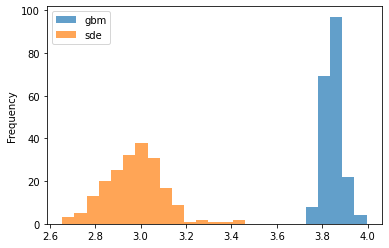

In [214]:
import pandas as pd
pd.DataFrame(
    {
        "gbm": ys_gbm[-1,:,0].cpu().numpy(),
        "sde": ys[-1,:,0].cpu().numpy()
    }
).plot.hist(alpha=0.7, bins=25);

## Training

Buscamos fitear los parámetros $\theta_i$ y $\phi_i$ de las NNs en instancia $i$ de entrenamiento tal que $W\big(R_t(\theta_i, \phi_i),\ S_t\big) \to_i 0$ para todos los instantes $t$ de la discretización del browniano.  

* $$ dR_t = \mu_{\theta_i}(t, R_t)\ dt + \sigma_{\phi_i}(t, R_t)\ dW_t $$

* $$ dS_t = a S_t \ dt + b \ S_t \ dB_t $$

In [223]:
# cargar estados anteriores para iterar por partes
try:
    sde.load_state_dict(torch.load("./state"))
    best_st = pd.read_csv("best_st.csv", index_col=[0]).iloc[:,0].values.tolist()
    best_rt = pd.read_csv("best_rt.csv", index_col=[0]).iloc[:,0].values.tolist()
    losses = pd.read_csv("losses.csv", index_col=[0]).iloc[:,0].values.tolist()
    best_loss = min(losses)
except: 
    print("Starting from zero!")
    losses = []
    best_st = best_rt =  None 
    best_loss = np.inf

Starting from zero!


In [222]:
! rm *.csv state

rm: cannot remove '*.csv': No such file or directory
rm: cannot remove 'state': No such file or directory


In [238]:
steps = 200
ts = torch.linspace(0, 1, 11)
batch_size = 200

mu, sigma = .25, .01 # µ y σ del GBM
sde = SDE(state_size=state_size, batch_size=batch_size, mlp_size=100, num_layers=1, tanh=False).to(device)
gbm = GBM_SDE(mu=mu, sigma=sigma).to(device)
opt = torch.optim.Adam(sde.parameters(), lr=0.1)

torch.autograd.set_detect_anomaly(True) # generar mensajes de errores si nos quedamos sin memoria

y0 = torch.full((batch_size, state_size), 3, device=device)
trange = tqdm.tqdm(range(steps))
for step in trange:
    # Nuevo batch, grad en 0
    opt.zero_grad()
    
    # generar traza del GBM
    bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
    st = torchsde.sdeint(gbm, y0, ts, method='euler', bm=bm)
    
    # generar traza de nuestra SDE
    bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
    rt = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)

    # media de EMD entre todos los instantes de las trazas
    wasserstein_loss = emd(st, rt, qtiles=51).mean()
    
    # guardar el ultimo instante del mejor entrenamiento
    if best_loss > wasserstein_loss.item():
        best_st = st[-1,:,0].cpu().detach().numpy() 
        best_rt = rt[-1,:,0].cpu().detach().numpy()
        best_loss = wasserstein_loss.item()
    
    losses.append(wasserstein_loss.item())
    # Computar grad
    wasserstein_loss.backward()
    # Optimizar sobre el batch
    opt.step()


100%|██████████████████████████████████████████████████████████████████████████| 200/200 [22:12<00:00,  6.66s/it]


<AxesSubplot:>

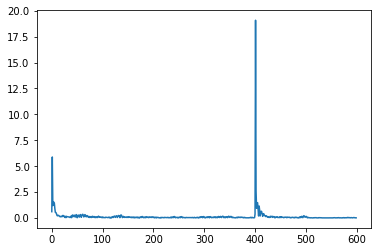

In [239]:
pd.Series(losses).plot()

<AxesSubplot:>

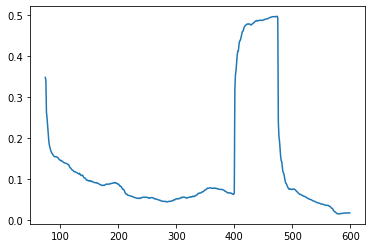

In [263]:
pd.Series(losses).rolling(75).mean().plot()

In [243]:
best_loss

0.004350206349045038

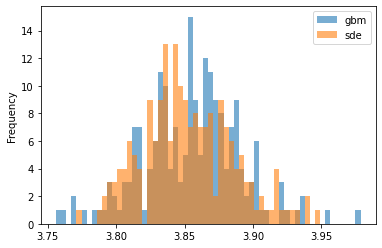

In [260]:
pd.DataFrame(
    {
        "gbm": best_st,
        "sde": best_rt
    }
).plot.hist(alpha=0.6, bins=60);

In [247]:
# Para guardar modelos

torch.save(sde.state_dict(), "./state")
pd.Series(best_st).to_csv("best_st.csv")
pd.Series(best_rt).to_csv("best_rt.csv")
pd.Series(losses).to_csv("losses.csv")

Samplear con un batch un poco más grande para verle mejor la pinta a las distribuciones

In [245]:
sts = rts = np.array([])
y0 = torch.full((batch_size, state_size), 3, device=device)
steps = 200

with torch.no_grad():
    for i in tqdm.tqdm(range(steps)):
        bm_ = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        st = torchsde.sdeint(gbm, y0, ts, method='euler', bm=bm)
        
        bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        rt = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm) 
        
        sts = np.append(sts, st[-1:, :, :][0,:,0].cpu().detach().numpy())
        rts = np.append(rts, rt[-1:, :, :][0,:,0].cpu().detach().numpy())

100%|██████████████████████████████████████████████████████████████████████████| 200/200 [07:05<00:00,  2.13s/it]


<AxesSubplot:ylabel='Frequency'>

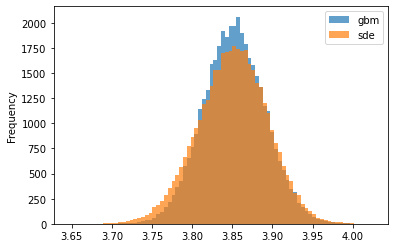

In [246]:
pd.DataFrame(
    {
        "gbm": sts,
        "sde": rts
    }
).plot.hist(alpha=0.7, bins=80)

## Pricing

Usando la medida de riesgo neutral con $r=0$ nos queda que el valor de la opción está dado al instante $t$ por:
$$ C(S, t) = \mathbb{E}(f(S_t + \int_t^T \sigma(S_t, t)\ dB)) $$

Para calcular lo que está entre paréntesis podemos resolver numéricamente con `torchsde.sdeint` usando la SDE neuronal pero resolviendo el proceso para drift nulo, $\mu(t,S_t) = 0$.

In [248]:
# Drift a 0 para evaluar en la medida 'neutral' (r = 0)
import copy
sde_neutral = copy.deepcopy(sde)
gbm_neutral = copy.deepcopy(gbm)
sde_neutral.f = gbm_neutral.f = lambda x,y: 0*x*y

sts = rts = np.array([])
y0 = torch.full((batch_size, state_size), 3, device=device)
steps = 200

with torch.no_grad():
    for i in tqdm.tqdm(range(steps)):
        bm_ = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        st = torchsde.sdeint(gbm_neutral, y0, ts, method='euler', bm=bm)
        
        bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        rt = torchsde.sdeint(sde_neutral, y0, ts, method='euler', bm=bm) 
        
        sts = np.append(sts, st[-1:, :, :][0,:,0].cpu().detach().numpy())
        rts = np.append(rts, rt[-1:, :, :][0,:,0].cpu().detach().numpy())

100%|██████████████████████████████████████████████████████████████████████████| 200/200 [06:44<00:00,  2.02s/it]


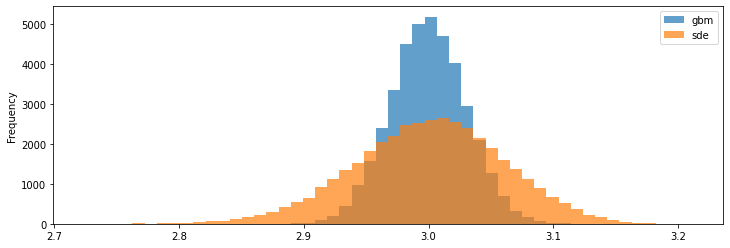

In [255]:
pd.DataFrame(
    {
        "gbm": sts,
        "sde": rts
    }
).plot.hist(alpha=0.7, bins=50, figsize=(12,4));

In [256]:
rts.mean(), sts.mean()

(3.00018857563138, 2.9998640016138554)

In [257]:
# Un viejo conocido de /Codigo/opcion_europea_bs.py

import math
from scipy.stats import norm
"""
opcion_europea_bs
Def
    Calculador del precio de una opcion Europea con el modelo de Black Scholes
Inputs
    - tipo : string - Tipo de contrato entre ["CALL","PUT"]
    - S : float - Spot price del activo
    - K : float - Strike price del contrato
    - T : float - Tiempo hasta la expiracion (en años)
    - r : float - Tasa 'libre de riesgo' (anualizada)
    - sigma : float - Volatilidad implicita (anualizada)
    - div : float - Tasa de dividendos continuos (anualizada)
Outputs
    - precio_BS: float - Precio del contrato
"""

def opcion_europea_bs(tipo, S, K, T, r, sigma, div):
    #Defino los ds
    d1 = (math.log(S / K) + (r - div + 0.5 * sigma * sigma) * T) / sigma / math.sqrt(T)
    d2 = (math.log(S / K) + (r - div - 0.5 * sigma * sigma) * T) / sigma / math.sqrt(T)

    if (tipo == "C"):
        precio_BS = math.exp(-div*T) *S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif (tipo == "P"):
        precio_BS = K * math.exp(-r * T) * norm.cdf(-d2) - math.exp(-div*T) * S * norm.cdf(-d1)
    return precio_BS

In [258]:
strikes = np.linspace(2.95, 3.06, 10)

gbm_vals = np.clip(sts.mean() - strikes, a_max=None, a_min=0)
sde_vals = np.clip(rts.mean() - strikes, a_max=None, a_min=0)
bs_vals = np.vectorize(
    lambda s: opcion_europea_bs(tipo="C", S=3, K=s, T=1, r=0, sigma=gbm_neutral.sigma, div=0)
)(strikes)

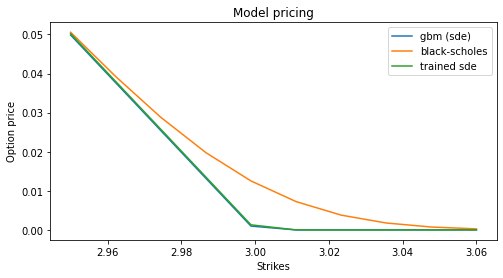

In [259]:
ax = pd.DataFrame(
    {
        "gbm (sde)": gbm_vals,
        "black-scholes": bs_vals,
        "trained sde": sde_vals
    },
    index=strikes
).plot(title='Model pricing', figsize=(8,4))
ax.set_xlabel("Strikes")
ax.set_ylabel("Option price");


Por formulación dual (Ramdas et al. [2015]) de la distancia de Wasserstein-1 vale 
$$ \mathbb{E}[f(R_t)] - \mathbb{E}[f(S_t)] < W(R_t, S_t) $$
considerando que la función de precios $f$ es una función Lipschitz-1.


[DeLis [2021]](https://arxiv.org/pdf/2105.13320.pdf) conjetura que para $W$ y $V$ medidas de martigala libres de riesgo para $R_t$ y $S_t$ además vale
$$ \big | \underbrace{\mathbb{E}_W[f(R_t)] - \mathbb{E}_V[f(S_t)]}_{C(R,t) - C(S,t)} \big |  <  \big | \mathbb{E}[f(R_t)] - \mathbb{E}[f(S_t)] \big | $$

Con lo que $C(R,t) \to C(S,t)$ cuando $W(R_t, S_t) \to 0$.